# Comparison of two simulations of highline

The purpose of this project is to compare two mathematical models of highline simulations. The first one is developped by Panos Athanasiadis and available on <a href=http://slackbro.pythonanywhere.com/backup/> SlackBro </a>, the second is developped by myself, and open source on <a href=https://github.com/AugustinMoinat/BackupFall-html-js>my github</a>.

I developped mine later, with more modern highline rigging style in mind, and it has more features. It allows to split the main and the back-up line in different segments and set-up configurations. But the interest of the older model resides in the fact that it has been tested (at least in part) by experimentations. 

The purpose of this work is to compare the two models and see in what measure the results differ.

We will start by looking at the interface of the Slackbro model. The parameters to enter are:
<ul>
    <li>m: Mass of slackliner (kg)</li>
    <li>D: Anchor-to-anchor distance (m)</li>
    <li>L: Length of backup webbing (m)</li>
    <li>ρ: Relative excess length (%)</li>
    <li>S: Mainline sag (m)</li>
    <li>d: Leash length (m)</li>
    <li>E: Stretch at 10kN (%)</li>
    <li>N: Number of taping points</li>
</ul>

The mass is the same in my model, the gap length just has a different name. The third and the fourth are equivalent: you have to choose one to use. We'll use L, the lenght of backup webbing. 

The mainline sag is not a given in my model: it comes out of the computation from given parameters of mainline. This means we'll have to run my model first and then only to get the inputs for the Slackbro model.

Leash length and stretch at 10kN are both identically set in my model.
The number of taping point plays no role in the dynamics, it is only used for display purposes.


Now, let's look at how we get the data out of that webpage. First, we need to import a few libraries.

In [1]:
import requests
from IPython.display import Javascript
from PIL import Image
from io import BytesIO
from base64 import b64decode
from bs4 import BeautifulSoup
import re
import numpy as np
import matplotlib.pyplot as plt
from pytesseract import pytesseract

# Install pytesseract and indicate the program path on your local machine 
# https://github.com/UB-Mannheim/tesseract/wiki
path_to_tesseract = r'C:\Users\AMO23276\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

#Point tessaract_cmd to tessaract.exe
pytesseract.tesseract_cmd = path_to_tesseract

## Getting results from slackbro

Now we are ready to make a request. The result is a webpage, and the only place on that page where the relevant data is, is on an image. Let's have a look.

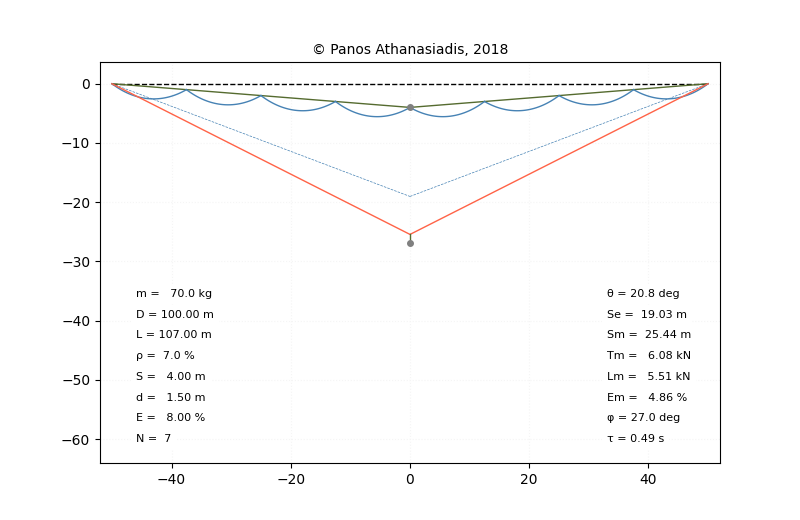

In [2]:
r = requests.post('http://slackbro.pythonanywhere.com/backup/', data={'m': 70,
                                                                      'D': 100,
                                                                      'L': 107,
                                                                      'ρ': '',
                                                                      'S': 4,
                                                                      'd': 1.5,
                                                                      'E': 8,
                                                                      'N': 7})

soup = BeautifulSoup(r.content, 'html.parser')

i = Image.open(BytesIO(b64decode(soup.img['src'][22:])))
i

The inputs are listed on the left, outputs on the right. Out of the 8 outputs, the only comparable outputs to my model are 
<ul>
    <li>Sm: the maximum sag in the fall</li>
    <li>Tm: the maximum tension in the line</li>
    <li>Lm: the maximume leash tension</li>
</ul>
To get them out of the image, we need to do a bit of image analysis, but first we crop the image to the relevant part. Fortunately, the image is always generated with the same dimensions.

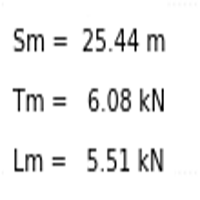

In [3]:
# crop to get only relevant data, resize bigger so the image analysis works.
i2 = i.crop((600, 320, 710, 390)).resize((200,200))
i2

In [2]:
def parse_result(image):
    text = pytesseract.image_to_string(image)
    match = re.search("Sm[ ]*=[ ]*([0-9\.]*)[ ]*m[ \n]*Tm[ ]*=[ ]*([0-9\.]*)[ ]*[kK]N[ \n]*Lm[ ]*=[ ]*([0-9\.]*)[ ]*[kK]N", text)
    return [ float(x) for x in match.groups()]

In [5]:
parse_result(i2)

[25.44, 6.08, 5.51]

Now, I will put all this process in a single function

In [3]:
def slack_bro(data):
    r = requests.post('http://slackbro.pythonanywhere.com/backup/', data=data)
    soup = BeautifulSoup(r.content, 'html.parser')
    i = Image.open(BytesIO(b64decode(soup.img['src'][22:])))
    i2 = i.crop((600, 320, 710, 390)).resize((200,200))
    return i2

## Interacting with my javascript calculator

I wanted to make a model that could run on a minimal tech: it's all coded in javascript, and runs on browser. That makes it a bit harder to communicate directly with it, even though I have access to all the source files. 
The steps are the following: 
<ul>
    <li> Decide what data I want to put in</li>
    <li> Generate the javascript code that runs the correct computations</li>
    <li> Use the method "Jupyter.notebook.kernel.execute" to assing the result to a python variable</li>
</ul>

Somehow, this runs on my machine only if I execute the cells one by one, not if I use Run all.

In [4]:
with open("../BUF/BackupFall-html-js/script-do-the-maths.js", "r") as f:
    do_the_maths=f.read()

The following function takes a list of Simulations as an input, and creates the javascript code to run them and update the results of the simulation. Because of kernel synchronisation issues, I cannot actually figure out how to call this function, I have to <b>copy-paste</b> its code everywhere.

In [5]:
def run_javascript(simulations):
    js_code = """
        %s;
        function essentialData(result){
            return {
                sag:-result.balancepoint[1],
                fMax:result.F1max,
                fLeash:result.FleashMax,
                sagMax:-result.backupFallpoint[3]
            }
        }
        """% do_the_maths

    for i,simul in enumerate(simulations):
        js_code +="""
        var basicData%s=%s;
        var result=essentialData(doTheMaths(basicData%s));
        var kernel = Jupyter.notebook.kernel;
        kernel.execute('simulations[%s].sag=' + result.sag)
        kernel.execute('simulations[%s].f_max=' + result.fMax);
        kernel.execute('simulations[%s].f_leash=' + result.fLeash);
        kernel.execute('simulations[%s].sag_max=' + result.sagMax)
        """%(i,simul.js_code(), i,i,i,i,i)

    Javascript(js_code)

Glad that this sorta works, now we need to 

## Generate test values

It's a bit more complex than necessary because the kernel doesn't synchronise well when called from inside the javascript code. So I need to run the loop inside the javascript.

First, let's create convenient classes and methods. Note that I have decided to add the weight of the setup to the weight of the slackliner when preparing the data for the slackbro request. This will be discussed later.

In [5]:
class Slacker:
    def __init__(self, w,h,l):
        self.w=w
        self.h=h
        self.l=l
        
class Setup:
    def __init__(self,mainL,mainE,backL,backE,weight):
        self.mainL = mainL
        self.mainK = 1000000 / (mainL * mainE)
        self.backL = backL
        self.backE = backE
        self.backK = 1000000 / (backL * backE)
        self.weight = weight
        
        
data_string= """{{
    slacker: {{w: {w}, h: {h}, l: {l}, p: {p}, b: 0}},
    spot: {{L: {L}, h1: 0, h2: 0}},
    setupWeight: {sew1},
    sections: [{{
        main: {{l: {ml}, k: {mk} }},
        backup: {{l: {bl}, k: {bk} }},
        weight: {sew1}
    }}],
    connections: [],
    breaks: [true]
}}"""      


class Simulation:
    def __init__(self,slacker,setup,L):
        self.slacker=slacker
        self.setup=setup
        self.L=L
        self.sag=0
        self.sag_max=0
        self.f_max=0
        self.f_leash=0
        self.slackbro_sag_max=0
        self.slackbro_f_max=0
        self.slackbro_f_leash=0
     
    def js_code(self):
        return data_string.format(w=self.slacker.w, h=self.slacker.h, l=self.slacker.l,p=self.L/2,
                                  L=self.L,sew1=self.setup.weight, ml=self.setup.mainL, 
                                  mk=self.setup.mainK, bl=self.setup.backL, bk=self.setup.backK)
        
        
    def get_slack_bro_result(self):
        data={
            'm': self.slacker.w+self.setup.weight, 
            'D': self.L,
            'L': self.setup.backL,
            'ρ': '',
            'S': self.sag,
            'd': self.slacker.l,
            'E': self.setup.backE,
            'N': 7
        }
        results = parse_result(slack_bro(data))
        self.slackbro_sag_max = results[0]
        self.slackbro_f_max = results[1]
        self.slackbro_f_leash = results[2]
        return results
    

In [6]:
def run_slackbro(simulations):
    print("running %s simulations"% len(simulations))
    for i,simul in enumerate(simulations):
        print("request %s to slackbro"% i)
        simul.get_slack_bro_result()

def percent_error(a,b):
    if b==0:
        return 100
    return 100*abs((a-b)/b)

def max_error(lista,listb):
    return max([percent_error(a,b) for a, b in zip(lista,listb)])
        
def make_graphs(simulations,param_list,param_name_description):
    sags=[simulation.sag for simulation in simulations]
    f_maxs=[simulation.f_max for simulation in simulations]
    f_leashs=[simulation.f_leash for simulation in simulations]
    sag_maxs=[simulation.sag_max for simulation in simulations]

    slackbro_f_maxs=[simulation.slackbro_f_max for simulation in simulations]
    slackbro_f_leashs=[simulation.slackbro_f_leash for simulation in simulations]
    slackbro_sag_maxs=[simulation.slackbro_sag_max for simulation in simulations]
    
    f_max_error = max_error(f_maxs,slackbro_f_maxs)
    f_leash_error = max_error(f_leashs,slackbro_f_leashs)
    sag_max_error = max_error(sag_maxs,slackbro_sag_maxs)    
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(10, 6))
    ax0.set_title('Lowest point')
    ax0.plot(param_list,sag_maxs, label="Augustin")
    ax0.plot(param_list,slackbro_sag_maxs, label="slackbro")
    ax0.text(0.5, -0.08, 'max error: {s:.2f} %'.format(s=sag_max_error), horizontalalignment='center',
     verticalalignment='center', transform=ax0.transAxes)
    ax0.legend()
    
    ax1.set_title('Force in anchors')
    ax1.plot(param_list,f_maxs, label="Augustin")
    ax1.plot(param_list,slackbro_f_maxs, label="slackbro")
    ax1.text(0.5, -0.08, 'max error: {f:.2f} %'.format(f=f_max_error), horizontalalignment='center',
     verticalalignment='center', transform=ax1.transAxes)
    ax1.legend()
    
    ax2.set_title('Force in leash')
    ax2.plot(param_list,f_leashs, label="Augustin")
    ax2.plot(param_list,slackbro_f_leashs, label="slackbro")
    ax2.text(0.5, -0.08, 'max error: {l:.2f} %'.format(l=f_leash_error), horizontalalignment='center',
     verticalalignment='center', transform=ax2.transAxes)
    ax2.legend()
    
    fig.suptitle(param_name_description)
    


### Influence of slackliner's height

In my modelisation, the height of the slackliner determines the point above the line from which the fall starts. In the slackbro model, there is no such parameter. 

For this initial simulation, I take a slackliner of 70kg, with a 1.5m leash. The setup is 100m long (low stretch main - sag follows), the backup webbing has 18% stretch at 10 kN, and is 105m long. The weight of the setup (main+backup) is 10kg

In [7]:
heights=np.arange(0,2.1,0.3)
slackers=[Slacker(70,h,1.5) for h in heights]
setup=Setup(100,1,105,18,10)
simulations=[Simulation(slacker, setup, 100) for slacker in slackers]
js_code = """
    %s;
    function essentialData(result){
        return {
            sag:-result.balancepoint[1],
            fMax:result.F1max,
            fLeash:result.FleashMax,
            sagMax:-result.backupFallpoint[3]
        }
    }
    """% do_the_maths

for i,simul in enumerate(simulations):
    js_code +="""
    var basicData%s=%s;
    var result=essentialData(doTheMaths(basicData%s));
    var kernel = Jupyter.notebook.kernel;
    kernel.execute('simulations[%s].sag=' + result.sag)
    kernel.execute('simulations[%s].f_max=' + result.fMax);
    kernel.execute('simulations[%s].f_leash=' + result.fLeash);
    kernel.execute('simulations[%s].sag_max=' + result.sagMax)
    """%(i,simul.js_code(), i,i,i,i,i)

Javascript(js_code)

<IPython.core.display.Javascript object>

running 8 simulations
request 0 to slackbro
request 1 to slackbro
request 2 to slackbro
request 3 to slackbro
request 4 to slackbro
request 5 to slackbro
request 6 to slackbro
request 7 to slackbro


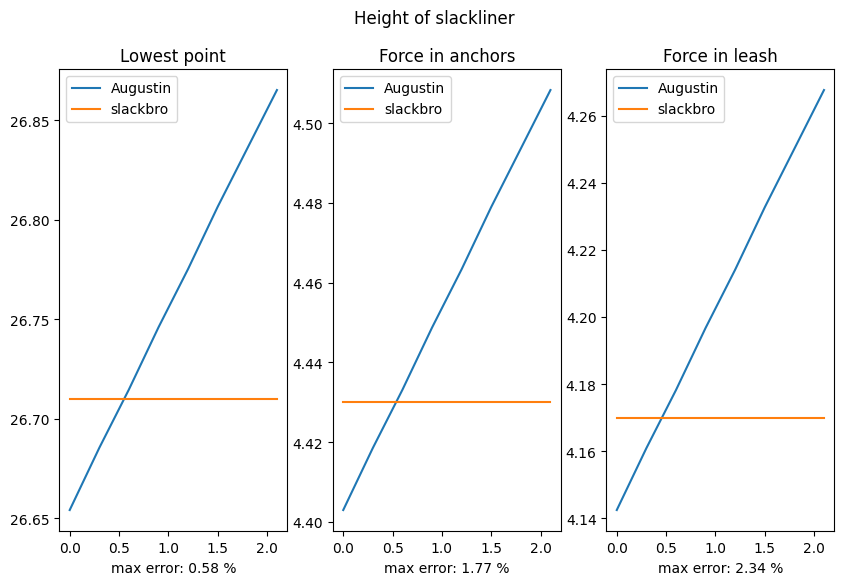

In [8]:
run_slackbro(simulations)

make_graphs(simulations,heights, "Height of slackliner")

#### Interpretation:

The first thing I would like to note is that the results are really similar. Somewhere around 0.4m of height seems to be the closest value.

### Influence of slackliner's weight

The slackliner falls from the line position, with a 1.5m leash. The setup is 100m long (low stretch main - sag follows), the backup webbing has 18% stretch at 10 kN, and is 105m long. The weight of the setup (main+backup) is 10kg

In [9]:
weights=np.arange(56,96,10)
slackers=[Slacker(w,0,1.5) for w in weights]
setup=Setup(100,1,105,18,10)
simulations=[Simulation(slacker, setup, 100) for slacker in slackers]
js_code = """
    %s;
    function essentialData(result){
        return {
            sag:-result.balancepoint[1],
            fMax:result.F1max,
            fLeash:result.FleashMax,
            sagMax:-result.backupFallpoint[3]
        }
    }
    """% do_the_maths

for i,simul in enumerate(simulations):
    js_code +="""
    var basicData%s=%s;
    var result=essentialData(doTheMaths(basicData%s));
    var kernel = Jupyter.notebook.kernel;
    kernel.execute('simulations[%s].sag=' + result.sag)
    kernel.execute('simulations[%s].f_max=' + result.fMax);
    kernel.execute('simulations[%s].f_leash=' + result.fLeash);
    kernel.execute('simulations[%s].sag_max=' + result.sagMax)
    """%(i,simul.js_code(), i,i,i,i,i)

Javascript(js_code)

<IPython.core.display.Javascript object>

running 4 simulations
request 0 to slackbro
request 1 to slackbro
request 2 to slackbro
request 3 to slackbro


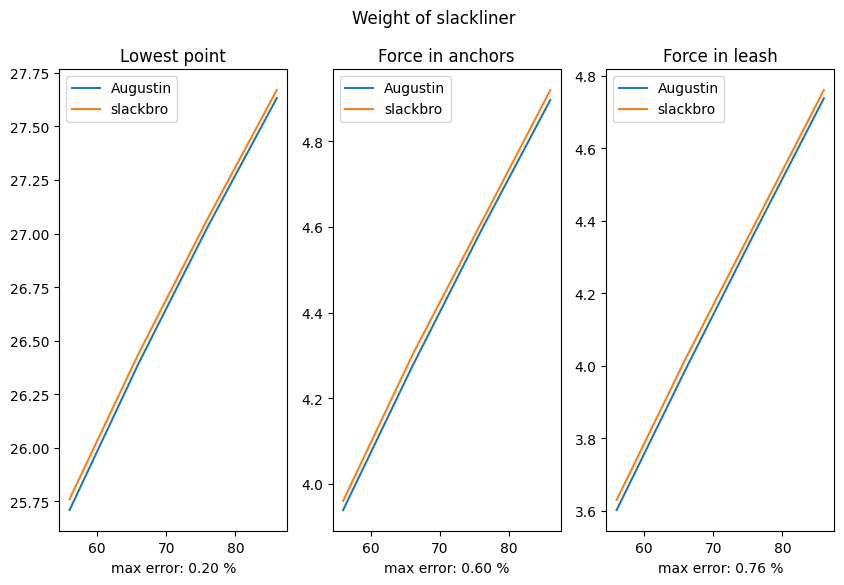

In [10]:
run_slackbro(simulations)
make_graphs(simulations,weights, "Weight of slackliner")

#### Interpretation:

These are really good results. The forces in the slackbro model are slightly higher with these parameters. This is consistent with the results we got from the height calculation.

### Influence of setup's weight

The slackliner weights 70kg, falls from the slackline position, with a 1.5m leash. The setup is 100m long (low stretch main - sag follows), the backup webbing has 18% stretch at 10 kN, and is 105m long.

In [11]:
weights=np.arange(0,12,1.5)
slacker=Slacker(70,0,1.5)
setups=[Setup(100,1,105,18,w) for w in weights]
simulations=[Simulation(slacker, setup, 100) for setup in setups]
js_code = """
    %s;
    function essentialData(result){
        return {
            sag:-result.balancepoint[1],
            fMax:result.F1max,
            fLeash:result.FleashMax,
            sagMax:-result.backupFallpoint[3]
        }
    }
    """% do_the_maths

for i,simul in enumerate(simulations):
    js_code +="""
    var basicData%s=%s;
    var result=essentialData(doTheMaths(basicData%s));
    var kernel = Jupyter.notebook.kernel;
    kernel.execute('simulations[%s].sag=' + result.sag)
    kernel.execute('simulations[%s].f_max=' + result.fMax);
    kernel.execute('simulations[%s].f_leash=' + result.fLeash);
    kernel.execute('simulations[%s].sag_max=' + result.sagMax)
    """%(i,simul.js_code(), i,i,i,i,i)

Javascript(js_code)

<IPython.core.display.Javascript object>

running 8 simulations
request 0 to slackbro
request 1 to slackbro
request 2 to slackbro
request 3 to slackbro
request 4 to slackbro
request 5 to slackbro
request 6 to slackbro
request 7 to slackbro


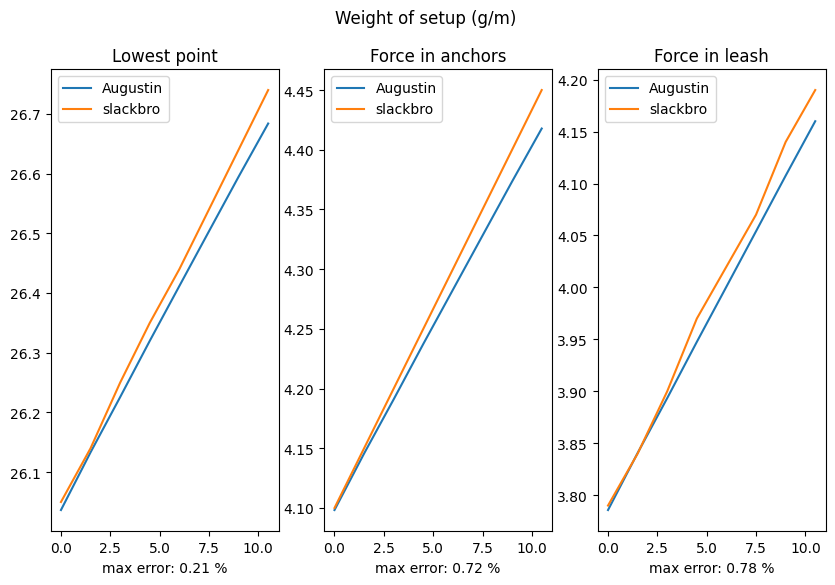

In [12]:
run_slackbro(simulations)
make_graphs(simulations,weights, "Weight of setup (kg)")

#### Interpretation:
With a heavier setup, even though the sag is increased and the fall happens from slightly lower, since the weight of the setup is added to the weight of the slackliner the results are very similar.

There is a slight discrepancy with heavier setups, which can be explained by the fact that, in my model, the potential energy computation takes into account the displacement of the setup. This effect makes the whole impact lower with a heavier setup.

### Influence of leash length

The slackliner weights 70kg, falls from the slackline position. The setup is 100m long (low stretch main - sag follows), the backup webbing has 18% stretch at 10 kN, and is 105m long. The weight of the setup (main+backup) is 10kg.

In [16]:
leashes=np.arange(0.1,1.9,0.5)
slackers=[Slacker(70,0,l) for l in leashes]
setup=Setup(100,1,105,18,10)
simulations=[Simulation(slacker, setup, 100) for slacker in slackers]
js_code = """
    %s;
    function essentialData(result){
        return {
            sag:-result.balancepoint[1],
            fMax:result.F1max,
            fLeash:result.FleashMax,
            sagMax:-result.backupFallpoint[3]
        }
    }
    """% do_the_maths

for i,simul in enumerate(simulations):
    js_code +="""
    var basicData%s=%s;
    var result=essentialData(doTheMaths(basicData%s));
    var kernel = Jupyter.notebook.kernel;
    kernel.execute('simulations[%s].sag=' + result.sag)
    kernel.execute('simulations[%s].f_max=' + result.fMax);
    kernel.execute('simulations[%s].f_leash=' + result.fLeash);
    kernel.execute('simulations[%s].sag_max=' + result.sagMax)
    """%(i,simul.js_code(), i,i,i,i,i)

Javascript(js_code)

<IPython.core.display.Javascript object>

running 4 simulations
request 0 to slackbro
request 1 to slackbro
request 2 to slackbro
request 3 to slackbro


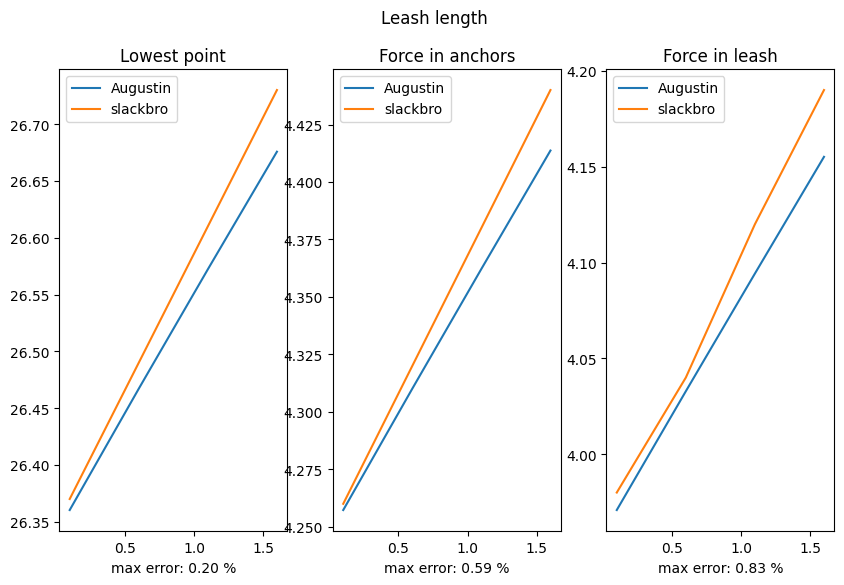

In [17]:
run_slackbro(simulations)
make_graphs(simulations,leashes, "Leash length")

#### Interpretation:
The difference becomes bigger with longer leash. This might be due to the fact that, in my model, the potential energy computation takes into account the displacement of the setup. With a longer leash, the displacement of the setup relative to the displacement of the slackliner is less.

### Influence of original sag

The slackliner weights 70kg, falls from the slackline position. The setup is 100m long, the backup webbing has 18% stretch at 10 kN, and is 105m long. The weight of the setup (main+backup) is 10kg.

By changing the stretch constant of the main, the original sag is changed.

In [18]:
stretchs=[0.1,0.5,1,2,5,10]
slacker=Slacker(70,0,1.5)
setups=[Setup(100,s,105,18,10) for s in stretchs]
simulations=[Simulation(slacker, setup, 100) for setup in setups]
js_code = """
    %s;
    function essentialData(result){
        return {
            sag:-result.balancepoint[1],
            fMax:result.F1max,
            fLeash:result.FleashMax,
            sagMax:-result.backupFallpoint[3]
        }
    }
    """% do_the_maths

for i,simul in enumerate(simulations):
    js_code +="""
    var basicData%s=%s;
    var result=essentialData(doTheMaths(basicData%s));
    var kernel = Jupyter.notebook.kernel;
    kernel.execute('simulations[%s].sag=' + result.sag)
    kernel.execute('simulations[%s].f_max=' + result.fMax);
    kernel.execute('simulations[%s].f_leash=' + result.fLeash);
    kernel.execute('simulations[%s].sag_max=' + result.sagMax)
    """%(i,simul.js_code(), i,i,i,i,i)

Javascript(js_code)

<IPython.core.display.Javascript object>

running 6 simulations
request 0 to slackbro
request 1 to slackbro
request 2 to slackbro
request 3 to slackbro
request 4 to slackbro
request 5 to slackbro


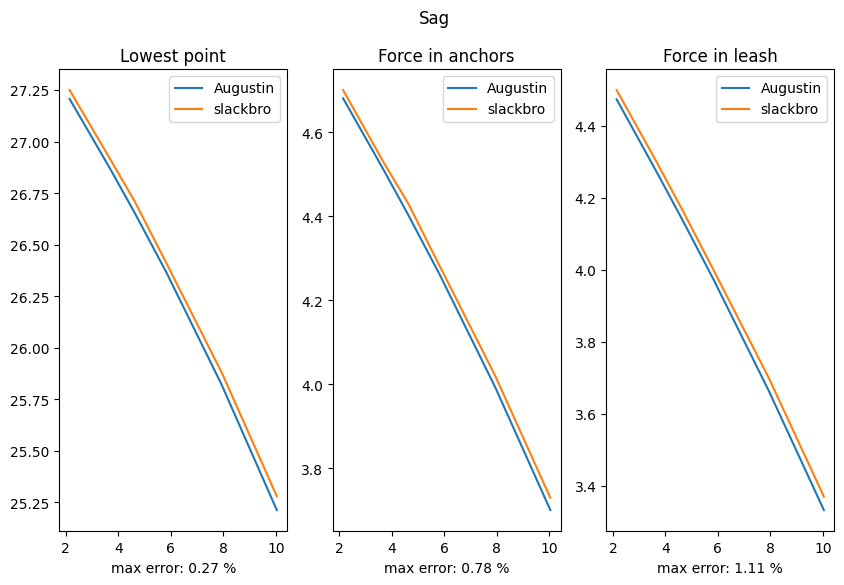

In [19]:
run_slackbro(simulations)
sags=[simulation.sag for simulation in simulations]
make_graphs(simulations,sags, "Sag")

#### Interpretation:
It's good.

### Influence of backup stretch
The slackliner weights 70kg, falls from the slackline position. The setup is 100m long (low stretch main - sag follows), the backup 105m long. The weight of the setup (main+backup) is 10kg.

In [21]:
stretchs=[1,2,3,5,8,11,18]
slacker=Slacker(70,0,1.5)
setups=[Setup(100,1,105,s,10) for s in stretchs]
simulations=[Simulation(slacker, setup, 100) for setup in setups]
js_code = """
    %s;
    function essentialData(result){
        return {
            sag:-result.balancepoint[1],
            fMax:result.F1max,
            fLeash:result.FleashMax,
            sagMax:-result.backupFallpoint[3]
        }
    }
    """% do_the_maths

for i,simul in enumerate(simulations):
    js_code +="""
    var basicData%s=%s;
    var result=essentialData(doTheMaths(basicData%s));
    var kernel = Jupyter.notebook.kernel;
    kernel.execute('simulations[%s].sag=' + result.sag)
    kernel.execute('simulations[%s].f_max=' + result.fMax);
    kernel.execute('simulations[%s].f_leash=' + result.fLeash);
    kernel.execute('simulations[%s].sag_max=' + result.sagMax)
    """%(i,simul.js_code(), i,i,i,i,i)

Javascript(js_code)

<IPython.core.display.Javascript object>

running 7 simulations
request 0 to slackbro
request 1 to slackbro
request 2 to slackbro
request 3 to slackbro
request 4 to slackbro
request 5 to slackbro
request 6 to slackbro


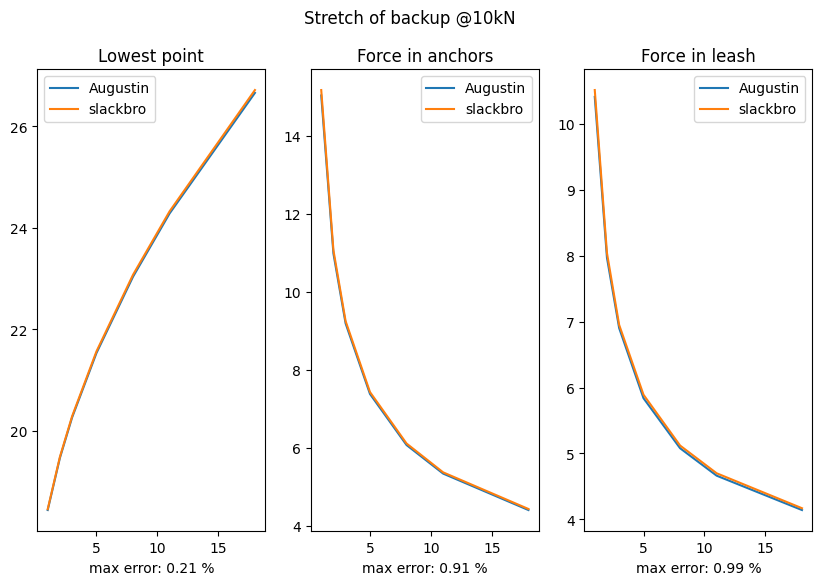

In [22]:
run_slackbro(simulations)
make_graphs(simulations,stretchs, "Stretch of backup @10kN ")

#### Interpretation:
It's good.

### Influence of backup length
The slackliner weights 70kg, falls from the slackline position. The setup is 100m long (low stretch main - sag follows), the backup has 18% stretch at 10 kN. The weight of the setup (main+backup) is 10kg.

In [27]:
lengths=[102,103,105,108,110,112]
slacker=Slacker(70,0,1.5)
setups=[Setup(100,1,l,18,10) for l in lengths]
simulations=[Simulation(slacker, setup, 100) for setup in setups]
js_code = """
    %s;
    function essentialData(result){
        return {
            sag:-result.balancepoint[1],
            fMax:result.F1max,
            fLeash:result.FleashMax,
            sagMax:-result.backupFallpoint[3]
        }
    }
    """% do_the_maths

for i,simul in enumerate(simulations):
    js_code +="""
    var basicData%s=%s;
    var result=essentialData(doTheMaths(basicData%s));
    var kernel = Jupyter.notebook.kernel;
    kernel.execute('simulations[%s].sag=' + result.sag)
    kernel.execute('simulations[%s].f_max=' + result.fMax);
    kernel.execute('simulations[%s].f_leash=' + result.fLeash);
    kernel.execute('simulations[%s].sag_max=' + result.sagMax)
    """%(i,simul.js_code(), i,i,i,i,i)

Javascript(js_code)

<IPython.core.display.Javascript object>

running 6 simulations
request 0 to slackbro
request 1 to slackbro
request 2 to slackbro
request 3 to slackbro
request 4 to slackbro
request 5 to slackbro


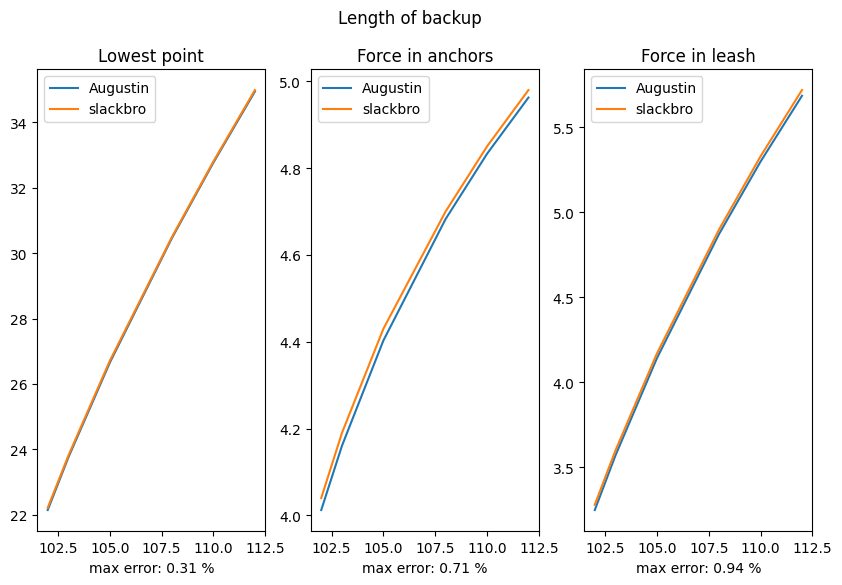

In [28]:
run_slackbro(simulations)
make_graphs(simulations,lengths, "Length of backup ")

#### Interpretation:
It's good.

### Influence of setup length
The slackliner weights 70kg, falls from the slackline position. The setup low stretch main - sag follows, the backup is 5% longer, and has 18% stretch at 10 kN. The weight of the setup (main+backup) is 100g/m.

In [36]:
lengths=[25,40,70,100,150,200,250]
slacker=Slacker(70,0,1.5)
setups=[Setup(l,1,l*1.05,18,l/10) for l in lengths]
simulations=[Simulation(slacker, setup, setup.mainL) for setup in setups]
js_code = """
    %s;
    function essentialData(result){
        return {
            sag:-result.balancepoint[1],
            fMax:result.F1max,
            fLeash:result.FleashMax,
            sagMax:-result.backupFallpoint[3]
        }
    }
    """% do_the_maths

for i,simul in enumerate(simulations):
    js_code +="""
    var basicData%s=%s;
    var result=essentialData(doTheMaths(basicData%s));
    var kernel = Jupyter.notebook.kernel;
    kernel.execute('simulations[%s].sag=' + result.sag)
    kernel.execute('simulations[%s].f_max=' + result.fMax);
    kernel.execute('simulations[%s].f_leash=' + result.fLeash);
    kernel.execute('simulations[%s].sag_max=' + result.sagMax)
    """%(i,simul.js_code(), i,i,i,i,i)

Javascript(js_code)

<IPython.core.display.Javascript object>

running 7 simulations
request 0 to slackbro
request 1 to slackbro
request 2 to slackbro
request 3 to slackbro
request 4 to slackbro
request 5 to slackbro
request 6 to slackbro


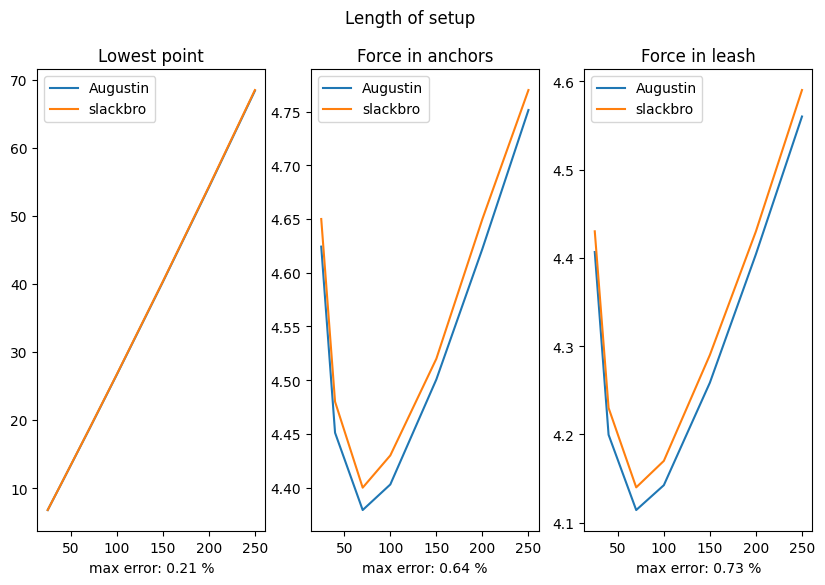

In [37]:
run_slackbro(simulations)
make_graphs(simulations,lengths, "Length of setup ")

#### Interpretation

It's not quite clear to me exactly why the force curves go up and down, but the important fact is that they stay close.

## Final word

In the end, I think this show that my model is really close to the model available at <a href=http://slackbro.pythonanywhere.com/backup/>Slackbro</a>. 
If I had chosen to not input the weight of the set-up plus the weight of the slackliner in the slackbro model, the differences would have been higher, but my model would have shown systematically higher forces. Since this is intended for worse case predictions, I think it validates my model.